# Demo

We run a minimum risk portfolio and perform an entire backtest

In [14]:
import numpy as np
import pandas as pd
import cvxpy as cp

from cvx.simulator.builder import builder
from cvx.risk.sample import SampleCovariance
from cvx.portfolio.min_risk import minrisk_problem

pd.options.plotting.backend = "plotly"

In [15]:
# Load some historic stock prices
prices = pd.read_csv('data/stock_prices.csv', index_col=0, parse_dates=True, header=0)

In [16]:
# Estimate a series of historic covariance matrices
returns = prices.pct_change().dropna(axis=0, how="all")
cov = returns.ewm(com=60, min_periods=100).cov().dropna(axis=0, how="all")
start = cov.index[0][0]

In [17]:
# Establish a risk model
from cvx.risk.sample import SampleCovariance
risk_model = SampleCovariance(num=20)

In [18]:
# Perform the backtest
_builder = builder(prices=prices.truncate(before=start), initial_cash=1e6)

w = cp.Variable(len(_builder.assets))
problem = minrisk_problem(risk_model, w)


for t, _ in _builder:
    risk_model.update(cov=cov.loc[t[-1]].values, lower_assets=np.zeros(20), upper_assets=np.ones(20))
    
    # don't reconstruct the problem in every iteration!
    problem.solve()
    
    _builder.set_weights(t[-1], pd.Series(data=w.value, index=_builder.assets))

portfolio = _builder.build()

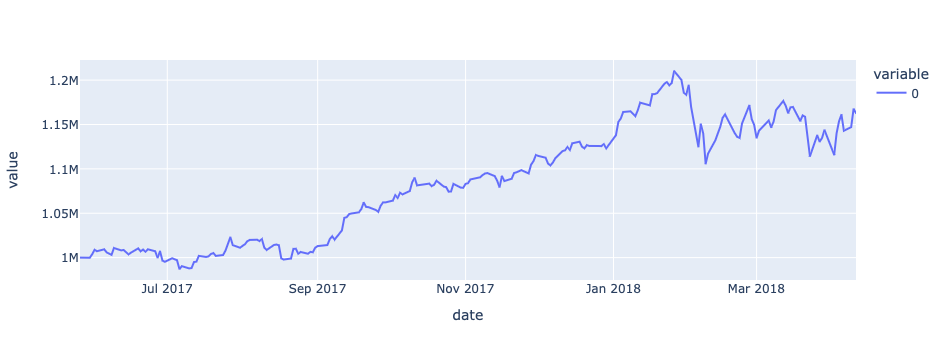

In [19]:
portfolio.nav.plot()

## Change of risk model

In [20]:
from cvx.risk.cvar import CVar
risk_model = CVar(alpha=0.80, n=40, m=20)

In [21]:
# Perform the backtest
_builder = builder(prices=prices.truncate(before=start), initial_cash=1e6)

w = cp.Variable(len(_builder.assets))
problem = minrisk_problem(risk_model, w)

for t, _ in _builder:
    risk_model.update(returns=returns.truncate(after=t[-1]).tail(40).values, lower_assets=np.zeros(20), upper_assets=np.ones(20))
    
    # don't reconstruct the problem in every iteration!
    problem.solve()
    
    _builder.set_weights(t[-1], pd.Series(data=w.value, index=_builder.assets))

portfolio = _builder.build()